## Basic Feature Processing

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import config
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import matplotlib.pyplot as plt

# Load the data
arrest_data = pd.read_csv(config.TRAIN_FILE_CLEAN[0])
non_arrest_data = pd.read_csv(config.TRAIN_FILE_CLEAN[1])
arrest_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
non_arrest_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Convert date column to datetime
arrest_data['Date'] = pd.to_datetime(arrest_data['Date'], format='%Y-%m-%d %H:%M:%S')
non_arrest_data['Date'] = pd.to_datetime(non_arrest_data['Date'], format='%Y-%m-%d %H:%M:%S')

# Filter data -> if overfit add more data
arrest_data = arrest_data[arrest_data['Date'] >= '2024-01-01'].copy()
non_arrest_data = non_arrest_data[non_arrest_data['Date'] >= '2024-01-01'].copy()  

In [48]:
# Define our prediction goal
# We will predict whether a specific grid will have more than the median crime rate in the next 24 hours

# Feature Engineering

# Temporal Features
def add_temporal_features(df):
    """Add time-based features to the dataframe."""

    # Basic time features
    df['hour'] = df['Date'].dt.hour
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['day_of_month'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Time of day categories
    df['time_of_day'] = pd.cut(
        df['hour'], 
        bins=[-1,6,12,18,24], 
        labels=['night', 'morning', 'afternoon', 'evening']
    )

    # Season categories
    df['season'] = pd.cut(df['month'],
                                bins=[0, 4, 7, 10, 13],
                                labels=['Spring','Summer','Fall', 'Winter'],
                                right=False)
    
    # One-hot encode
    time_of_day_dummies = pd.get_dummies(df['time_of_day'], prefix='time')
    season_dummies = pd.get_dummies(df['season'], prefix='season')
    df = pd.concat([df, time_of_day_dummies, season_dummies], axis=1)
    df =  df.drop(['time_of_day', 'season'], axis=1)
    
    # Holidays (US holidays - simplified for demo)
    holidays = [
        # New Year's Day
        pd.Timestamp(year=y, month=1, day=1) for y in range(2001, 2026)
    ] + [
        # Independence Day
        pd.Timestamp(year=y, month=7, day=4) for y in range(2001, 2026)
    ] + [
        # Christmas
        pd.Timestamp(year=y, month=12, day=25) for y in range(2001, 2026)
    ]
    
    df['is_holiday'] = df['Date'].isin(holidays).astype(int)
    df = df.drop(['Date'], axis=1) # Date no longer needed

    return df

# Spatial Features - Add grid coordinates 
def add_spatial_features(df, grid):
    """Extract spatial features from the grid columns."""
    # 6hour, 1day, 1week, 1month, 3month, 1year
    WINDOW_SECS = config.WINDOW_SECS
    grid_columns = [c for c in df.columns if '_' in c]

    # This can capture the spread and transmission of crime in time and space
    def find_nearby_grid(grid, distance):
        x, y = grid.split('_')
        x, y = int(x), int(y)
        nearby_grids = {grid}
        for _ in range(distance):
            new_grids = set()
            for grid in nearby_grids:
                x, y = grid.split('_')
                x, y = int(x), int(y)
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        nx, ny = x + dx, y + dy
                        new_grid = str(nx) + '_' + str(ny)
                        if new_grid in grid_columns and new_grid not in nearby_grids:
                            new_grids.add(new_grid)
            nearby_grids.update(new_grids)
        return list(nearby_grids)

    dist_list = ['dist0', 'dist1', 'dist2', 'dist3', 'dist4']
    dist_grids = {}
    for dist in dist_list:
        dist_grids[dist] = find_nearby_grid(grid, int(dist[-1]))
    for window in WINDOW_SECS:
        for dist in dist_list:
            fcol = dist + '_' + str(window)
            # use mean to fix the problem of the boundary grid
            df[fcol] = df[dist_grids[dist]].rolling(window=window, min_periods=1).sum().mean(axis=1)
    df = df.iloc[WINDOW_SECS[-1]:]
    return df


# Function to prepare target variable
def prepare_target(df, grid, threshold_percentile=50, prediction_window=24):
    """
    Create target variable: 1 if crime is above threshold in next window, else 0
    """
    # Calculate future crime counts (sum over next prediction_window hours)
    future_crime = pd.DataFrame(index=df.index)

    # Sum crime counts over next prediction_window hours
    future_crime[grid] = df[grid].rolling(window=prediction_window).sum().shift(-prediction_window)

    # Determine threshold for each grid
    thresholds = {}
    thresholds[grid] = np.percentile(future_crime[grid].dropna(), threshold_percentile)
    
    # Create binary target: 1 if crime is above threshold, 0 otherwise
    df[f'target'] = (future_crime[grid] > thresholds[grid]).astype(int)
    
    return df


In [49]:
# Modified function to prepare data for all grids
def prepare_all_grids_data(arrest_data, non_arrest_data):
    """
    Prepare data for all grids at once to train a single model
    """
    import warnings
    from pandas.errors import PerformanceWarning
    
    # Suppress PerformanceWarning
    warnings.filterwarnings("ignore", category=PerformanceWarning)
    
    print("Preparing prediction model for all grids...")

    # Get all grid columns
    grid_columns = [col for col in non_arrest_data.columns if '_' in col]
    
    # 1. Add temporal features, only need once
    print("Adding temporal features...")
    arrest_data = add_temporal_features(arrest_data)
    non_arrest_data = non_arrest_data.drop(columns=['Date'])

    print(f"Processing {len(grid_columns)} grids...")
    
    # 2. Create a combined dataframe for all grids
    all_data = []
    
    for grid in tqdm(grid_columns):
        # print(f"Processing grid {grid}...")
        arrest_temp = arrest_data.copy()
        non_arrest_temp = non_arrest_data.copy()
  
        # Add spatial features
        arrest_temp = add_spatial_features(arrest_temp, grid)
        non_arrest_temp = add_spatial_features(non_arrest_temp, grid)
                
        # Create target variable, record in arrest
        # if target is non_arrest, also can record in arrest
        arrest_temp = prepare_target(arrest_temp, grid)
        
        # drop grid
        arrest_temp = arrest_temp.drop(columns=grid_columns)
        non_arrest_temp = non_arrest_temp.drop(columns=grid_columns)

        # rename columns to avoid name conflict
        arrest_temp.columns = ['arst_' + col if 'dist' in col else col for col in arrest_temp.columns]
        non_arrest_temp.columns = ['narst_' + col if 'dist' in col else col for col in non_arrest_temp.columns]

        # Combine features
        features = pd.concat([arrest_temp, non_arrest_temp], axis=1)

        # Add grid identifier
        features['grid_id'] = grid

        # Reset index to avoid duplicate indices when concatenating
        features.reset_index(drop=True, inplace=True)
        
        # Append to our collection
        all_data.append(features)
    
    # print(len(all_data))
    # for df in all_data:
    #     print(df.columns.tolist())
    #     print(df.head(3))
    #     print(df.index.is_unique)
    

    # Combine all grid data into one dataframe
    combined_data = pd.concat(all_data, axis=0, ignore_index=True)
    
    # not meaningful, we have solved NA in preprocessing
    # # Feature selection - remove features with more than 50% missing values
    # missing_ratio = combined_data.isna().mean()
    # combined_data = combined_data.drop(columns=missing_ratio[missing_ratio > 0.5].index)
    
    # # Fill remaining missing values
    # combined_data = combined_data.fillna(0)
    
    # Extract target
    y = combined_data['target']
    X = combined_data.drop(columns=['target'])
    
    return X, y

In [50]:
X, y = prepare_all_grids_data(arrest_data, non_arrest_data)

Preparing prediction model for all grids...
Adding temporal features...
Processing 72 grids...


100%|██████████| 72/72 [00:21<00:00,  3.28it/s]


## Model Training Framework

In [51]:
# Create a framework for model training and evaluation
def train_model(model, X_train, X_val, y_train, y_val, name="Model"):
    """
    Train a model and evaluate its performance
    
    Parameters:
    -----------
    model: The model to train
    X_train, X_val: Training and validation features
    y_train, y_val: Training and validation targets
    name: Name of the model for display
    
    Returns:
    --------
    model: Trained model
    metrics: Dictionary of performance metrics
    """
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate metrics
    roc = roc_auc_score(y_val, y_pred_proba)
    
    # Get precision-recall curve and AUC
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Classification report for more detailed metrics
    report = classification_report(y_val, y_pred, output_dict=True)
    
    # Store metrics
    metrics = {
        'roc_auc': roc,
        'pr_auc': pr_auc,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1': report['1']['f1-score'],
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred,
        'precision_curve': precision,
        'recall_curve': recall
    }
    
    print(f"{name} ROC-AUC: {roc:.4f}, PR-AUC: {pr_auc:.4f}")
    print(f"Precision: {report['1']['precision']:.4f}, Recall: {report['1']['recall']:.4f}, F1: {report['1']['f1-score']:.4f}")
    
    return model, metrics

In [52]:
# Data preparation
def prepare_data(X, y, test_size=0.2, random_state=42):
    """
    Prepare data for model training
    
    Parameters:
    -----------
    X, y: Features and target
    test_size: Proportion of data to use for testing
    random_state: Random seed for reproducibility
    
    Returns:
    --------
    X_train, X_val, y_train, y_val: Train and validation sets
    """
    # Get categorical columns (one-hot encoded)
    cat_cols = [col for col in X.columns if col.startswith('time_') or 
                col.startswith('season_') or
                col == 'is_weekend' or 
                col == 'is_holiday' or
                col == 'grid_id']
    
    # Convert grid_id to numerical if it isn't already
    if 'grid_id' in X.columns and X['grid_id'].dtype == 'object':
        grid_encoder = LabelEncoder()
        X['grid_id'] = grid_encoder.fit_transform(X['grid_id'])
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Scale numerical features
    num_cols = [col for col in X.columns if col not in cat_cols]
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_val[num_cols] = scaler.transform(X_val[num_cols])
    
    return X_train, X_val, y_train, y_val, scaler, num_cols, cat_cols

In [53]:
# 1. Train XGBoost model
def train_xgboost(X_train, X_val, y_train, y_val):
    # Define XGBoost parameters
    params = {
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 1,
        'gamma': 0,
        'random_state': 42
    }
    
    # Create and train model
    model = xgb.XGBClassifier(**params)
    return train_model(model, X_train, X_val, y_train, y_val, name="XGBoost")

# 2. Train LightGBM model
def train_lightgbm(X_train, X_val, y_train, y_val):
    # Define LightGBM parameters
    params = {
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'binary',
        'metric': 'auc',
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_samples': 20,
        'random_state': 42
    }
    
    # Create and train model
    model = lgb.LGBMClassifier(**params)
    return train_model(model, X_train, X_val, y_train, y_val, name="LightGBM")

# 3. Train Random Forest model
def train_random_forest(X_train, X_val, y_train, y_val):
    # Define Random Forest parameters
    params = {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create and train model
    model = RandomForestClassifier(**params)
    return train_model(model, X_train, X_val, y_train, y_val, name="Random Forest")

# 4. Train Logistic Regression model
def train_logistic_regression(X_train, X_val, y_train, y_val):
    # Define Logistic Regression parameters
    params = {
        'C': 1.0,
        'penalty': 'l2',
        'solver': 'liblinear',
        'random_state': 42,
        'max_iter': 200
    }
    
    # Create and train model
    model = LogisticRegression(**params)
    return train_model(model, X_train, X_val, y_train, y_val, name="Logistic Regression")

## Model Evaluation

In [54]:
def plot_model_comparisons(all_metrics):
    """
    Visualize and compare model performance metrics
    
    Parameters:
    -----------
    all_metrics: Dictionary of metrics for each model
    """
    # Set up figure and axes
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    
    # Create a DataFrame with all metrics for comparison
    metrics_df = pd.DataFrame({
        'Model': list(all_metrics.keys()),
        'ROC-AUC': [metrics['roc_auc'] for metrics in all_metrics.values()],
        'PR-AUC': [metrics['pr_auc'] for metrics in all_metrics.values()],
        'F1 Score': [metrics['f1'] for metrics in all_metrics.values()],
        'Precision': [metrics['precision'] for metrics in all_metrics.values()],
        'Recall': [metrics['recall'] for metrics in all_metrics.values()]
    }).sort_values('ROC-AUC', ascending=False)
    
    # 1. Combined AUC metrics bar plot (ROC-AUC and PR-AUC)
    auc_metrics = pd.melt(
        metrics_df, 
        id_vars=['Model'], 
        value_vars=['ROC-AUC', 'PR-AUC'],
        var_name='AUC Type', 
        value_name='Score'
    )
    
    sns.barplot(x='Model', y='Score', hue='AUC Type', data=auc_metrics, ax=axes[0, 0])
    axes[0, 0].set_title('AUC Scores by Model', fontsize=14)
    axes[0, 0].set_xlabel('Model', fontsize=12)
    axes[0, 0].set_ylabel('Score', fontsize=12)
    axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)
    
    # 2. Precision-Recall-F1 comparison
    metrics_melted = pd.melt(
        metrics_df, 
        id_vars=['Model'], 
        value_vars=['Precision', 'Recall', 'F1 Score'],
        var_name='Metric', 
        value_name='Value'
    )
    
    sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_melted, ax=axes[0, 1])
    axes[0, 1].set_title('Precision, Recall, and F1 by Model', fontsize=14)
    axes[0, 1].set_xlabel('Model', fontsize=12)
    axes[0, 1].set_ylabel('Score', fontsize=12)
    axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
    
    # 3. Metrics Table
    # Hide the original axis
    axes[0, 2].axis('off')
    
    # Create a table with all metrics
    metrics_table = pd.DataFrame({
        'Model': metrics_df['Model'],
        'ROC-AUC': metrics_df['ROC-AUC'].round(4),
        'PR-AUC': metrics_df['PR-AUC'].round(4),
        'Precision': metrics_df['Precision'].round(4),
        'Recall': metrics_df['Recall'].round(4),
        'F1 Score': metrics_df['F1 Score'].round(4)
    })
    
    table = axes[0, 2].table(
        cellText=metrics_table.values,
        colLabels=metrics_table.columns,
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    axes[0, 2].set_title('Model Performance Metrics', fontsize=14, pad=20)
    
    # ROC curves for all models
    for model_name, metrics in all_metrics.items():
        if model_name == 'DNN' and 'history' in metrics:
            # Skip DNN history plot here
            continue
            
        fpr, tpr, _ = roc_curve(y_val, metrics['y_pred_proba'])
        axes[1, 0].plot(fpr, tpr, label=f"{model_name} (AUC={metrics['roc_auc']:.3f})")
    
    axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_title('ROC Curves', fontsize=14)
    axes[1, 0].set_xlabel('False Positive Rate', fontsize=12)
    axes[1, 0].set_ylabel('True Positive Rate', fontsize=12)
    axes[1, 0].legend(loc="lower right")
    
    # PR curves for all models
    for model_name, metrics in all_metrics.items():
        if model_name == 'DNN' and 'history' in metrics:
            # Skip DNN history plot here
            continue
            
        precision, recall, _ = precision_recall_curve(y_val, metrics['y_pred_proba'])
        axes[1, 1].plot(recall, precision, label=f"{model_name} (AUC={metrics['pr_auc']:.3f})")
    
    # Add baseline for PR curve (class imbalance ratio)
    no_skill = len(y_val[y_val == 1]) / len(y_val)
    axes[1, 1].plot([0, 1], [no_skill, no_skill], 'k--', label='No Skill')
    axes[1, 1].set_xlim([0.0, 1.0])
    axes[1, 1].set_ylim([0.0, 1.05])
    axes[1, 1].set_title('Precision-Recall Curves', fontsize=14)
    axes[1, 1].set_xlabel('Recall', fontsize=12)
    axes[1, 1].set_ylabel('Precision', fontsize=12)
    axes[1, 1].legend(loc="best")
    
    # Confusion matrix for best model
    best_model_name = metrics_df.iloc[0]['Model']
    best_metrics = all_metrics[best_model_name]
    
    cm = confusion_matrix(y_val, best_metrics['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 2])
    axes[1, 2].set_title(f'Confusion Matrix - {best_model_name}', fontsize=14)
    axes[1, 2].set_xlabel('Predicted', fontsize=12)
    axes[1, 2].set_ylabel('Actual', fontsize=12)
    axes[1, 2].set_xticklabels(['No', 'Yes'])
    axes[1, 2].set_yticklabels(['No', 'Yes'])
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot - Confusion matrices for all models
    num_models = len(all_metrics)
    fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 5))
    
    if num_models == 1:
        axes = [axes]  # Convert to list if only one model
    
    for i, (model_name, metrics) in enumerate(all_metrics.items()):
        if 'y_pred' in metrics:
            cm = confusion_matrix(y_val, metrics['y_pred'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'{model_name}\nConfusion Matrix', fontsize=14)
            axes[i].set_xlabel('Predicted', fontsize=12)
            axes[i].set_ylabel('Actual', fontsize=12)
            axes[i].set_xticklabels(['No', 'Yes'])
            axes[i].set_yticklabels(['No', 'Yes'])
    
    plt.tight_layout()
    plt.show()
    
    # Display feature importance for best model if available
    if hasattr(models[best_model_name], 'feature_importances_'):
        plt.figure(figsize=(12, 8))
        feature_imp = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': models[best_model_name].feature_importances_
        }).sort_values('Importance', ascending=False).head(20)
        
        sns.barplot(x='Importance', y='Feature', data=feature_imp)
        plt.title(f'Top 20 Features in Best Model ({best_model_name})', fontsize=14)
        plt.tight_layout()
        plt.show()

## Main function

Training XGBoost...
XGBoost ROC-AUC: 0.9874, PR-AUC: 0.9632
Precision: 0.9504, Recall: 0.7924, F1: 0.8643
Training LightGBM...
[LightGBM] [Info] Number of positive: 4546, number of negative: 14865
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13774
[LightGBM] [Info] Number of data points in the train set: 19411, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234197 -> initscore=-1.184762
[LightGBM] [Info] Start training from score -1.184762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

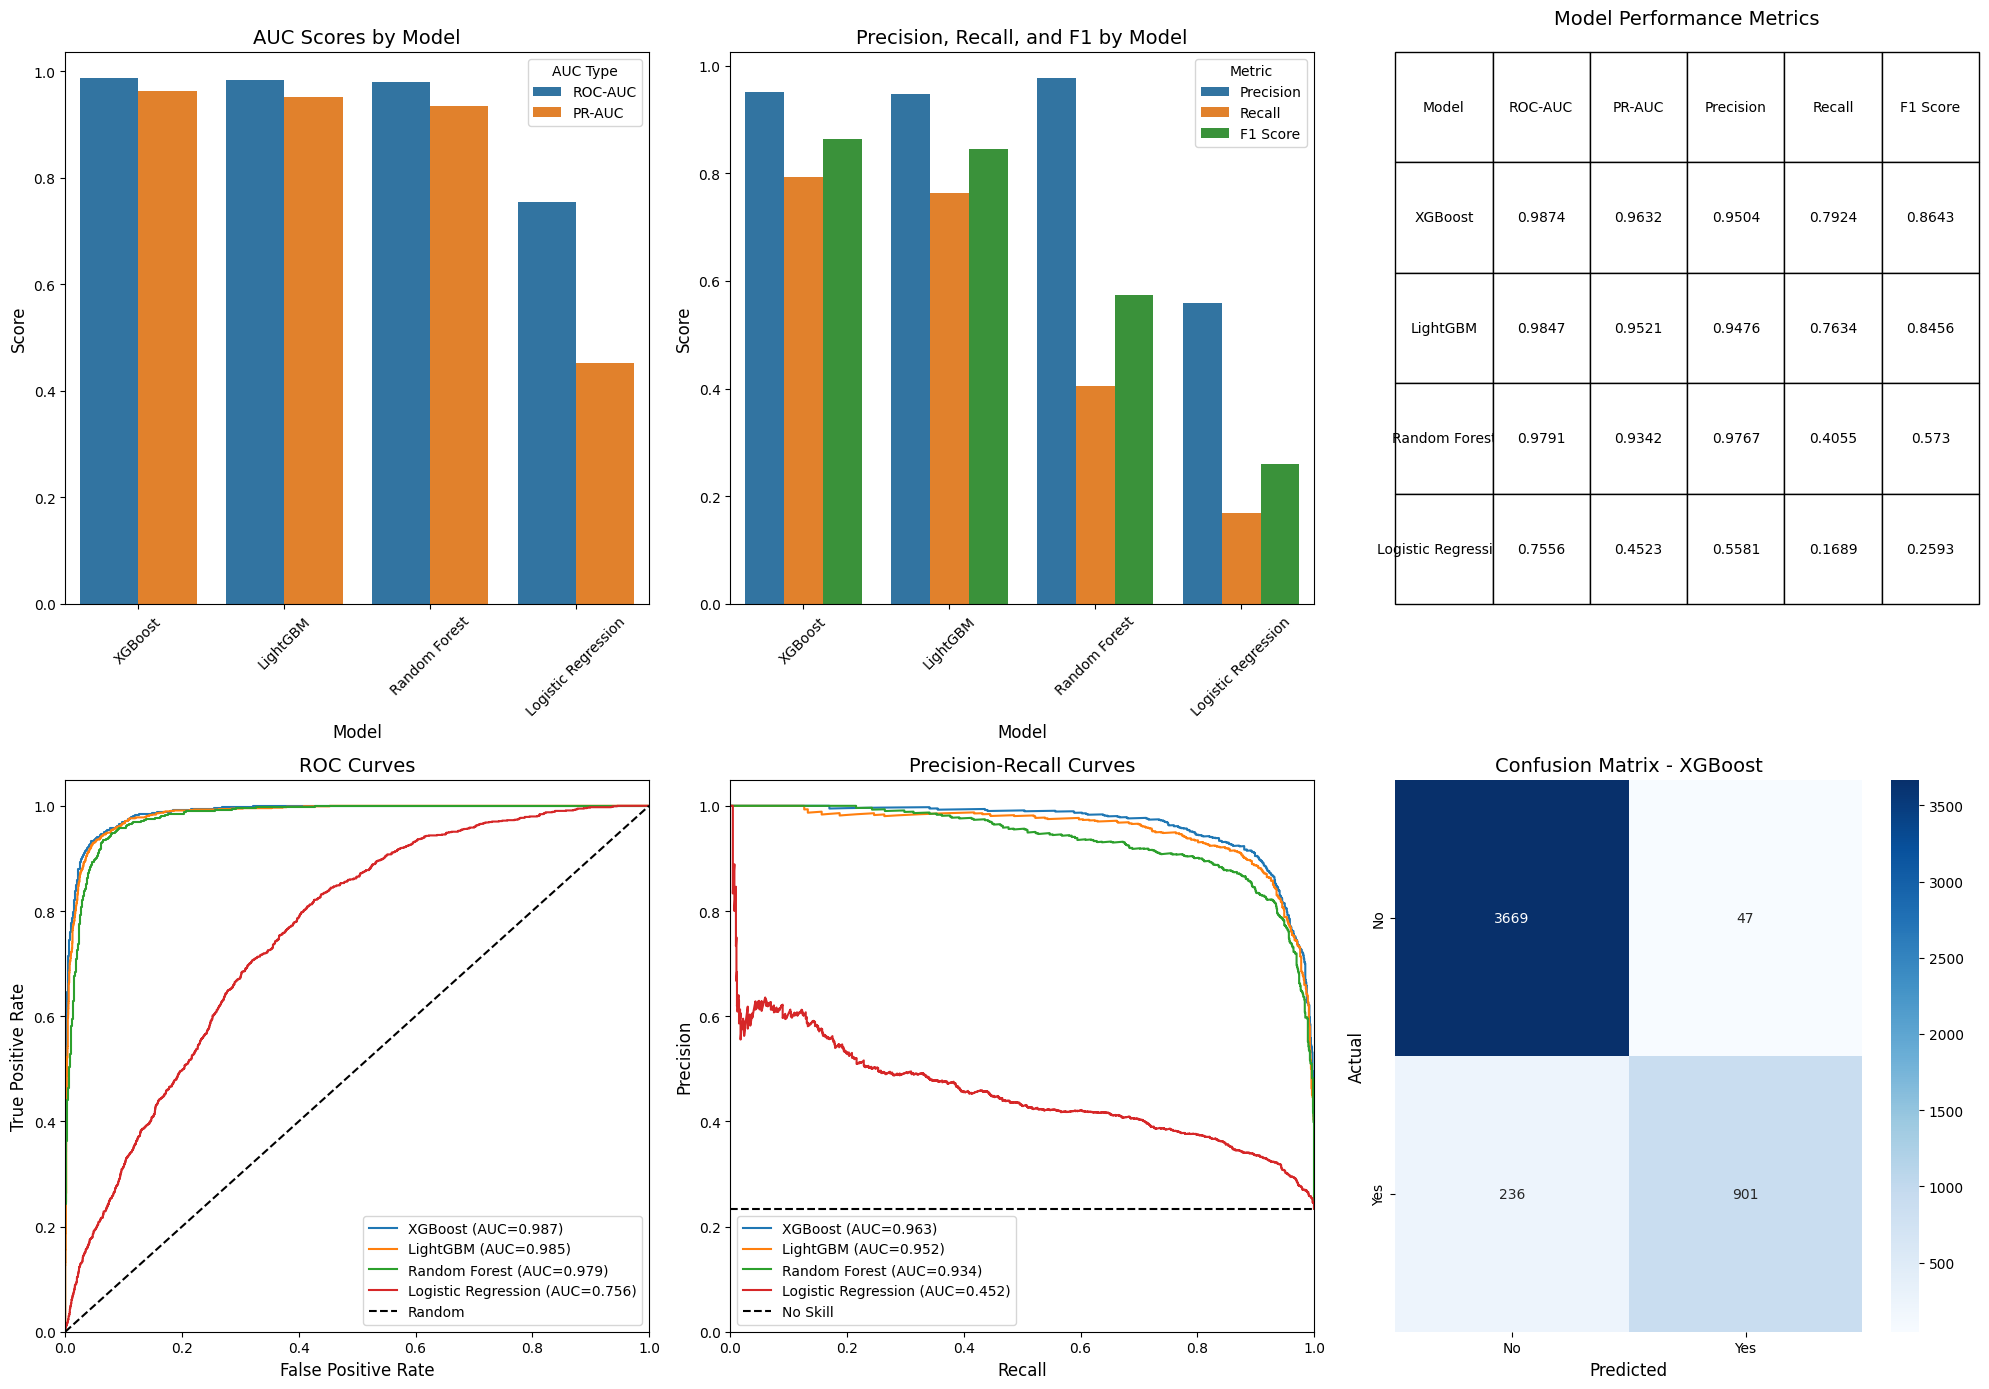

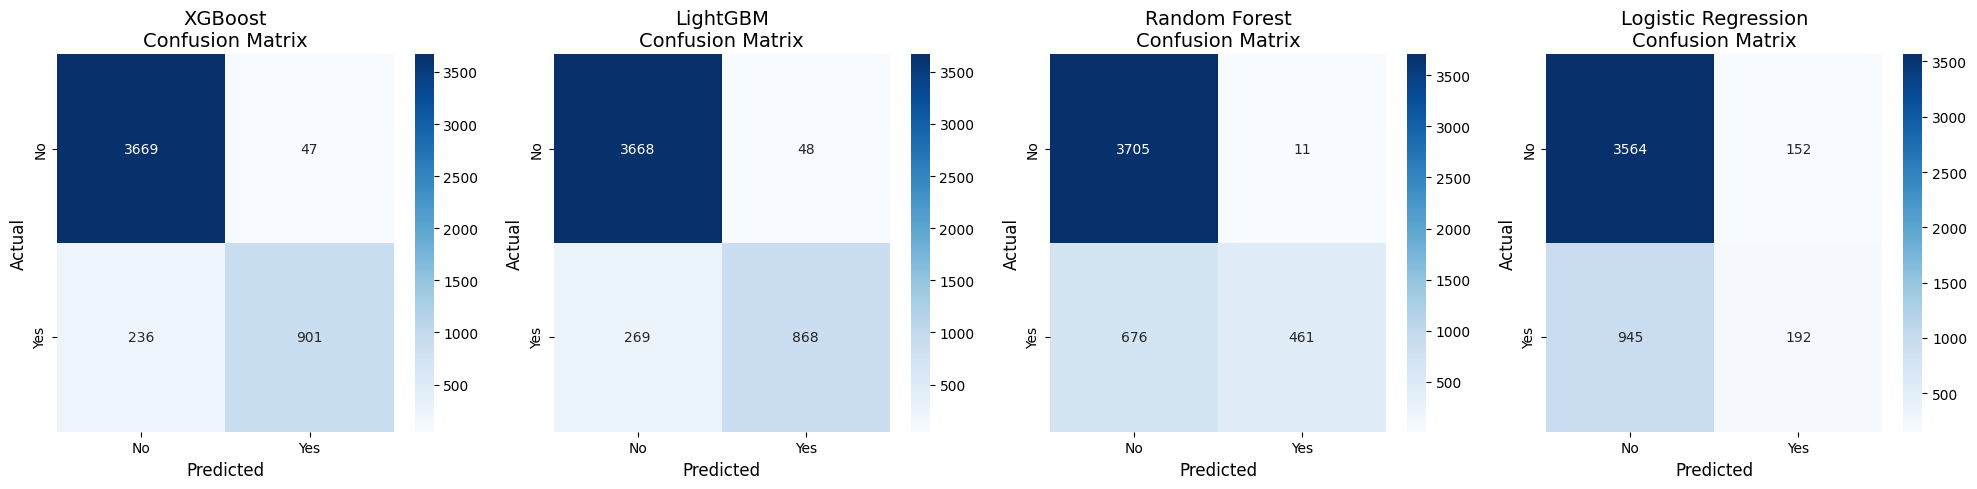

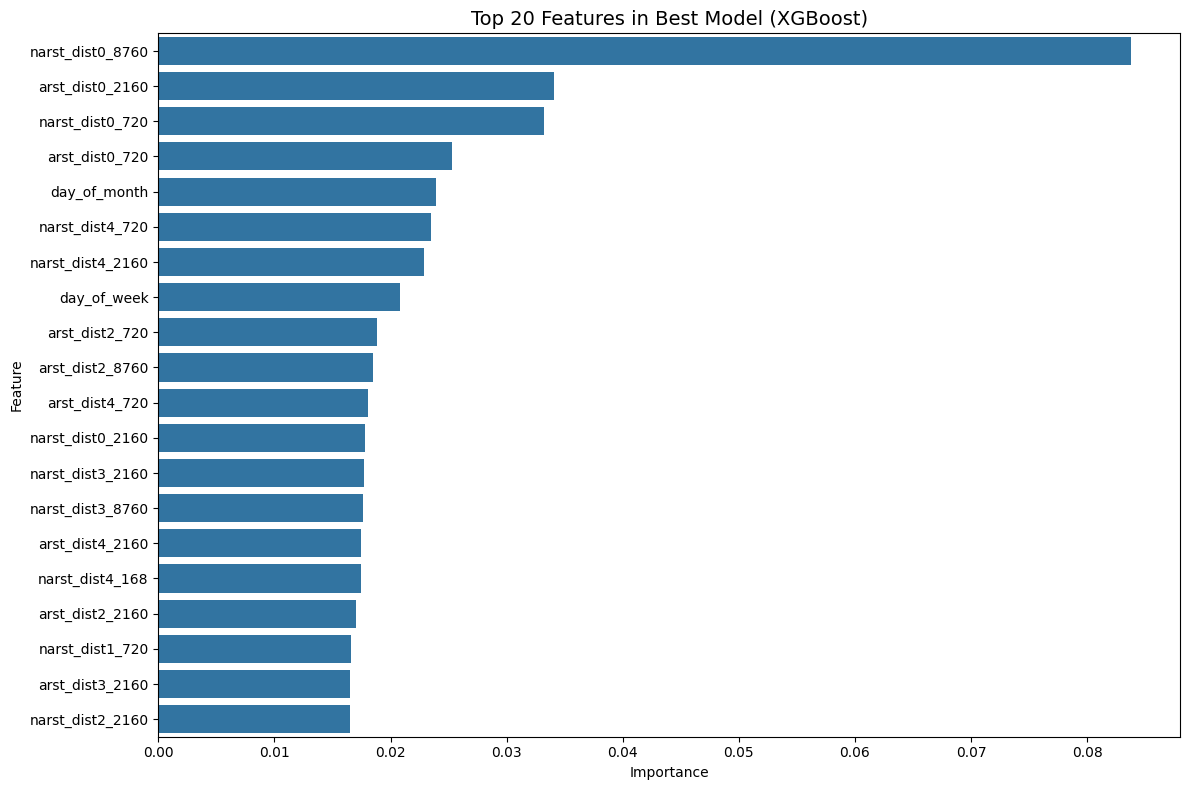


Best model: XGBoost

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3716
           1       0.95      0.79      0.86      1137

    accuracy                           0.94      4853
   macro avg       0.94      0.89      0.91      4853
weighted avg       0.94      0.94      0.94      4853


Classification Report for All Models:

XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3716
           1       0.95      0.79      0.86      1137

    accuracy                           0.94      4853
   macro avg       0.94      0.89      0.91      4853
weighted avg       0.94      0.94      0.94      4853


LightGBM:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3716
           1       0.95      0.76      0.85      1137

    accuracy                           0.93      4853
   macro

In [55]:
# Prepare data
X_train, X_val, y_train, y_val, scaler, num_cols, cat_cols = prepare_data(X, y)

# Train all models
models = {}
metrics = {}

# 1. XGBoost
models['XGBoost'], metrics['XGBoost'] = train_xgboost(X_train, X_val, y_train, y_val)

# 2. LightGBM
models['LightGBM'], metrics['LightGBM'] = train_lightgbm(X_train, X_val, y_train, y_val)

# 3. Random Forest
models['Random Forest'], metrics['Random Forest'] = train_random_forest(X_train, X_val, y_train, y_val)

# 4. Logistic Regression
models['Logistic Regression'], metrics['Logistic Regression'] = train_logistic_regression(X_train, X_val, y_train, y_val)

# Compare model performance
plot_model_comparisons(metrics)

# Get the best model based on ROC-AUC
best_model_name = max(metrics.items(), key=lambda x: x[1]['roc_auc'])[0]
print(f"\nBest model: {best_model_name}")

# Print classification report for the best model
best_y_pred = metrics[best_model_name]['y_pred']
print("\nClassification Report for Best Model:")
print(classification_report(y_val, best_y_pred))

# Print classification report for all models
print("\nClassification Report for All Models:")
for model_name, model_metrics in metrics.items():
    print(f"\n{model_name}:")
    print(classification_report(y_val, model_metrics['y_pred']))
